In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave                          # saving wave files
from playsound import playsound      # playing audio files
from IPython.display import Audio    # playing audio in IPython

ModuleNotFoundError: No module named 'playsound'

In [2]:
with open("putty.log", "rb") as file:
    result = file.read()

FileNotFoundError: [Errno 2] No such file or directory: 'putty.log'

### Converting from Encrypted Data

The following two cells come from this [repository](https://github.com/IvanEvan/Vox2Wav-by-python) written by IvanEvan. It converts VOX ADPCM to a wav file or a 16 bit array (whichever is preferred). The code has been debugged some, but it's generally much nicer than scratch. There are some resources online for how to decode this data that are may be worth reading if we continue this encryption. This likely can be coded in C and I think we should improve this code.

In [3]:
# table of  quantizer step size
StepSizeTable = [16, 17, 19, 21, 23, 25, 28, 31, 34, 37, 41,
                 45, 50, 55, 60, 66, 73, 80, 88, 97, 107, 118, 130, 143, 157, 173,
                 190, 209, 230, 253, 279, 307, 337, 371, 408, 449, 494, 544, 598, 658,
                 724, 796, 876, 963, 1060, 1166, 1282, 1408, 1552]

# table of index
IndexTable = [-1, -1, -1, -1, 2, 4, 6, 8]

# This method maybe not work, never be checked
def ADPCM_Encode(sample):
    global index
    global predsample

    code = 0

    step_size = StepSizeTable[index]

    # compute diff and record sign and absolut value
    diff = sample - predsample
    if diff < 0:
        code = 8
        diff = -diff

    # quantize the diff into ADPCM code
    # inverse quantize the code into a predicted diff
    tmpstep = step_size
    diffq = step_size >> 3

    if diff >= tmpstep:
        code = code | 0x04
        diff -= tmpstep
        diffq = diffq + step_size

    tmpstep = tmpstep >> 1

    if diff >= tmpstep:
        code = code | 0x02
        diff = diff - tmpstep
        diffq = diffq + (step_size >> 1)

    tmpstep = tmpstep >> 1

    if diff >= tmpstep:
        code = code | 0x01
        diffq = diffq + (step_size >> 2)

    # fixed predictor to get new predicted sample
    if code & 8:
        predsample = predsample - diffq
    else:
        predsample = predsample + diffq

    # check for overflow
    if predsample > 32767:
        predsample = 32767
    elif predsample < -32768:
        predsample = -32768

    # find new stepsize index
    index += IndexTable[code]

    # check for overflow
    if index < 0:
        index = 0

    if index > 48:
        index = 48

    # return new ADPCM code   code & 0x0f == code
    return code & 0x0f


# ADPCM_Decode.
# code: a byte containing a 4-bit ADPCM sample.
# retval : 16-bit ADPCM sample
de_index = 0
de_predsample = 0

# Work well
def ADPCM_Decode(code):
    global de_index
    global de_predsample

    step_size = StepSizeTable[de_index]

    # inverse code into diff
    diffq = step_size >> 3  # == step/8
    if code & 4:
        diffq += step_size

    if code & 2:
        diffq += step_size >> 1

    if code & 1:
        diffq += step_size >> 2

    # add diff to predicted sample
    if code & 8:
        diffq = -diffq

    de_predsample += diffq

    # check for overflow  clip the values to +/- 2^11 (supposed to be 16 bits)
    if de_predsample > 2047:
        de_predsample = 2047
    elif de_predsample < -2048:
        de_predsample = -2048

    # find new quantizer step size
    de_index += IndexTable[code]

    # check for overflow
    if de_index < 0:
        de_index = 0

    if de_index > 48:
        de_index = 48

    # save predict sample and de_index for next iteration
    # return new decoded sample
    # The original algorithm turned out to be 12bit, need to convert to 16bit
    return de_predsample << 4

In [4]:
list_8bit_bytes = result

list_16bit = []
for i in range(len(list_8bit_bytes)):
    byte_i = list_8bit_bytes[i]  # 1 bytes = 8bit
    high_4bit = (byte_i & 0xf0) >> 4  # split high 4bit from 8bit
    low_4bit = byte_i & 0x0f  # split low 4bit from 8bit

    # first sample
    sample_0 = high_4bit
    # unsigned to signed
    # 4bit : -2^4 ~ 2^(4-1)-1
    if sample_0 > 7:
        sample_4bit_0 = sample_0 - 16
    else:
        sample_4bit_0 = sample_0

    # second sample
    sample_1 = low_4bit
    # unsigned to signed
    if sample_1 > 7:
        sample_4bit_1 = sample_1 - 16
    else:
        sample_4bit_1 = sample_1

    # now decode
    tmpDeS16_0 = ADPCM_Decode(sample_4bit_0)
    tmpDeS16_1 = ADPCM_Decode(sample_4bit_1)

    list_16bit.extend([tmpDeS16_0, tmpDeS16_1])

wav_file = wave.open('putty.wav', 'wb')

# configure channel number, quantization size, and sample rate
wav_file.setnchannels(1)
wav_file.setsampwidth(2)
wav_file.setframerate(16000)
# converts data to binary data and writes it to a file
wav_file.writeframes(np.array(list_16bit, dtype=np.int16).tobytes())
wav_file.close()

### Plot Data

As a proof of concept this should look the same as importing from raw data in audacity. As a reminder, see this [Simplicity page](https://docs.silabs.com/bluetooth/2.13/code-examples/applications/voice-over-ble#source) for instructions with Audacity.

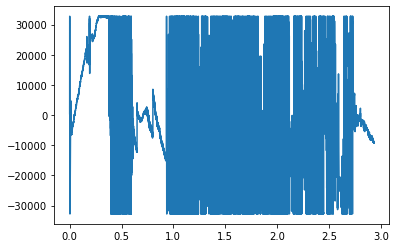

In [12]:
T = np.arange(len(list_16bit))/16000
plt.plot(T,list_16bit)

### Audio

The following shows a couple ways of playing audio, most use a wave file.

In [23]:
# A few ways to play audio
# 
# If you need to play the audio... this accepts wav and mp3
# playsound('putty.wav')
# 
# This is a good way in Jupyter the following are equivalent
# Audio(data=np.array(list_16bit, dtype=np.int16), rate=16000)
# Audio(filename='putty.wav', rate=16000)